# MSc Project
## Adaptive Classifier for Concept Drift with Web Interface for Fraud DetectionStakeholder

In [1]:
import zipfile
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import joblib

import warnings
warnings.filterwarnings('ignore')

# 1. Extracting and Subsetting


_N:B: Section 1 only needs to be run once (the first time this notebook is run) with archive.zip. The results of this extracting and subsetting is saved in the "data/processed/paysim_subsample.csv" file and is used forward from Section 2._

## 1.1. Extract from archive

In [ ]:
# !! cell can be commented out after the first run as it has served it's purpose !!
# extract data from archive

zip_file = "data/raw/archive.zip"
extract_dir = "data/raw/"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## 1.2. Load and Inspect Data

In [7]:
full_data_dir = "data/raw/PS_20174392719_1491204439457_log.csv"
full_df = pd.read_csv(full_data_dir)

In [8]:
print(full_df.info())
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
print(f"Full Dataset: {len(full_df)} row, Fraud Rate: {full_df['isFraud'].mean():.4f}")

Full Dataset: 6362620 row, Fraud Rate: 0.0013


In [10]:
# check for missing data
full_df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## 1.3. Subsample Data
Select a subsample of 100,000 records

In [11]:
full_df = full_df.reset_index(names='original_index') # preserve original index for temporality
full_df.head()

,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# select all fraud cases
fraud_df = full_df[full_df['isFraud']==1]
print(fraud_df.info())
fraud_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8213 entries, 2 to 6362619
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_index  8213 non-null   int64  
 1   step            8213 non-null   int64  
 2   type            8213 non-null   object 
 3   amount          8213 non-null   float64
 4   nameOrig        8213 non-null   object 
 5   oldbalanceOrg   8213 non-null   float64
 6   newbalanceOrig  8213 non-null   float64
 7   nameDest        8213 non-null   object 
 8   oldbalanceDest  8213 non-null   float64
 9   newbalanceDest  8213 non-null   float64
 10  isFraud         8213 non-null   int64  
 11  isFlaggedFraud  8213 non-null   int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 834.1+ KB
None


,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [13]:
# select non-fraud cases to make up 100,000 records
to_select = 120000
count_req_non_fraud = to_select - len(fraud_df) # number of fraud cases required to make up 100000 total cases
count_total_non_fraud = len(full_df) - len(fraud_df) # total number of fraud cases in dataset
non_fraud_ratio = count_req_non_fraud / count_total_non_fraud # fraction of required to total,  to ensure proportional subseting

nonfraud_df = full_df[full_df['isFraud']==0].groupby('step').sample(frac=non_fraud_ratio, random_state=42)
print(nonfraud_df.info())
nonfraud_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 111785 entries, 1795 to 6361797
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   original_index  111785 non-null  int64  
 1   step            111785 non-null  int64  
 2   type            111785 non-null  object 
 3   amount          111785 non-null  float64
 4   nameOrig        111785 non-null  object 
 5   oldbalanceOrg   111785 non-null  float64
 6   newbalanceOrig  111785 non-null  float64
 7   nameDest        111785 non-null  object 
 8   oldbalanceDest  111785 non-null  float64
 9   newbalanceDest  111785 non-null  float64
 10  isFraud         111785 non-null  int64  
 11  isFlaggedFraud  111785 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 11.1+ MB
None


,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1795,1795,1,PAYMENT,353.90,C1746117425,3.00,0.00,M467146800,0.00,0.00,0,0
2233,2233,1,CASH_OUT,159657.10,C1366629983,0.00,0.00,C716083600,2640580.83,2444985.19,0,0
372,372,1,TRANSFER,438437.09,C977160959,0.00,0.00,C248609774,740675.45,6453430.91,0,0
539,539,1,PAYMENT,207.75,C1288108586,82149.35,81941.60,M1089584667,0.00,0.00,0,0
2440,2440,1,PAYMENT,11380.13,C1905114489,77037.91,65657.79,M538132628,0.00,0.00,0,0


In [14]:
subsample_df = pd.concat([fraud_df, nonfraud_df], ignore_index=True)
# sort transactions by original index
subsample_df = subsample_df.sort_values(by='original_index').reset_index(drop=True)
# drop the original index
subsample_df.drop(columns=["original_index"], inplace=True)
print(subsample_df.info())
subsample_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119998 entries, 0 to 119997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            119998 non-null  int64  
 1   type            119998 non-null  object 
 2   amount          119998 non-null  float64
 3   nameOrig        119998 non-null  object 
 4   oldbalanceOrg   119998 non-null  float64
 5   newbalanceOrig  119998 non-null  float64
 6   nameDest        119998 non-null  object 
 7   oldbalanceDest  119998 non-null  float64
 8   newbalanceDest  119998 non-null  float64
 9   isFraud         119998 non-null  int64  
 10  isFlaggedFraud  119998 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 10.1+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,710544.77,C835773569,0.0,0.0,C1359044626,738531.50,16518.36,0,0
3,1,CASH_OUT,220691.42,C1123559518,0.0,0.0,C1590550415,6093090.62,19169204.93,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.0,0.0,C972765878,0.00,0.00,1,0


In [15]:
print(f"Subsample Dataset: {len(subsample_df)} rows")
print("_________Composed Of_________")
print(f"{len(subsample_df.query('isFraud==1'))} Fraud Cases")
print(f"{len(subsample_df.query('isFraud==0'))} Non-Fraud Cases")
print(f"Fraud Rate: {subsample_df['isFraud'].mean():.4f}")

Subsample Dataset: 119998 rows
_________Composed Of_________
8213 Fraud Cases
111785 Non-Fraud Cases
Fraud Rate: 0.0684


99,999 cases have been retrieved (rather than an exact 100,000) due to proportional subsampling.

In [15]:
# save the subset data
subsample_path = "data/processed/paysim_subsample.csv"
subsample_df.to_csv(subsample_path, index=False)

# 2. Preprocess Data

Process Data into format needed for model training and other subsequent manipulation

## 2.1 Load Subsampled Dataset
Load and inspect susbsampled dataset

In [2]:
df = pd.read_csv("data/processed/paysim_subsample.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            99999 non-null  int64  
 1   type            99999 non-null  object 
 2   amount          99999 non-null  float64
 3   nameOrig        99999 non-null  object 
 4   oldbalanceOrg   99999 non-null  float64
 5   newbalanceOrig  99999 non-null  float64
 6   nameDest        99999 non-null  object 
 7   oldbalanceDest  99999 non-null  float64
 8   newbalanceDest  99999 non-null  float64
 9   isFraud         99999 non-null  int64  
 10  isFlaggedFraud  99999 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,710544.77,C835773569,0.0,0.0,C1359044626,738531.50,16518.36,0,0
3,1,CASH_OUT,220691.42,C1123559518,0.0,0.0,C1590550415,6093090.62,19169204.93,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.0,0.0,C972765878,0.00,0.00,1,0


Inspect data

In [3]:
print("Unique value counts")
for col in df.columns:
    print(f"{col} - {df[col].nunique()}")

Unique value counts
step - 743
type - 5
amount - 95430
nameOrig - 99995
oldbalanceOrg - 54174
newbalanceOrig - 39810
nameDest - 93093
oldbalanceDest - 55496
newbalanceDest - 60388
isFraud - 2
isFlaggedFraud - 2


## 2.2. Feature Engineering and Selection

Select features, excluding:
- high cardinality data: nameOrig, nameDest
- Engineer new feature (isMerchant) from nameDest
- others: isFlaggedFraud. This is only a baseline system and will only be used as to derive baseline metrics for the system being built.

In [4]:
# add a flag to flag merchant destination accounts
df['isMerchant'] = df.nameDest.str.startswith('M').astype('int')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.00,0.00,1,0,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.00,0.00,1,0,0
2,1,TRANSFER,710544.77,C835773569,0.0,0.0,C1359044626,738531.50,16518.36,0,0,0
3,1,CASH_OUT,220691.42,C1123559518,0.0,0.0,C1590550415,6093090.62,19169204.93,0,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.0,0.0,C972765878,0.00,0.00,1,0,0


In [5]:
# list out features to select. step is excluded here because it will be used to engineer a new feature
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isMerchant']
X = df[features]
y = df['isFraud']

# Engineer time feature from step (step represents time units in hours). Results in 0-23hrs for each day
df['hour'] = (df['step'] % 24).astype(int)

# add it into the X set
X['hour'] = df['hour']
# add hour to the list of features
features.append('hour')

# preserve the amount unscaled for use in cost evaluation
unscaled_amount = df['amount'].copy()

# normalize features
# standard scaler normalizes data with mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## 2.3. Apply SMOTE for Oversampling

- Cut the data into three time periods (necessary for simulating drift)
- Apply SMOTE to each of the time periods separately (necessary to avoid synthetic data not specific to time period, and to avoid length mismatch)

The scaler and SMOTE cannot handle string variables, hence the labels have to be added after applying both.

In [403]:
# Simulate Concept Drift: split data into three time periods
periods = [i for i in range(1, 7)]
df['time_period'] = pd.qcut(df['step'], q=6, labels=periods)

# Initialize SMOTE (1:3 fraud-to-non-fraud), will be applied separately for each time period
smote = SMOTE(random_state=42, sampling_strategy=0.32)

# add unscaled amount to X_scaled before oversampling
X_scaled['unscaled_amount'] = unscaled_amount
features.append('unscaled_amount')

X_bal_list, y_bal_list = [], []
for period in periods:
    mask = df['time_period'] == period
    X_period = X_scaled[mask][features]
    y_period = y[mask]

    # apply SMOTE
    X_bal, y_bal = smote.fit_resample(X_period, y_period)
    X_bal['time_period'] = period

    X_bal_list.append(X_bal)
    y_bal_list.append(pd.Series(y_bal))

X_balanced = pd.concat(X_bal_list, ignore_index=True)
y_balanced = pd.concat(y_bal_list, ignore_index=True)

In [404]:
X_balanced.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isMerchant,hour,unscaled_amount,time_period
0,-0.300032,-0.304034,-0.279313,-0.327973,-0.351882,-0.673781,-2.984775,181.00,1
1,-0.300032,-0.304034,-0.279313,-0.321436,-0.351882,-0.673781,-2.984775,181.00,1
2,0.455659,-0.304096,-0.279313,-0.100077,-0.347180,-0.673781,-2.984775,710544.77,1
3,-0.065451,-0.304096,-0.279313,1.552226,5.104851,-0.673781,-2.984775,220691.42,1
4,-0.297239,-0.303135,-0.279313,-0.327973,-0.351882,-0.673781,-2.984775,2806.00,1


In [381]:
X_balanced.time_period.value_counts()

time_period
3    21278
2    21094
5    21007
4    20962
1    20184
6    16629
Name: count, dtype: int64

In [406]:
print(f"Post-SMOTE: {len(X_balanced)} rows, Fraud rate: {y_balanced.mean()}")

# save preprocessed X and y data, and save scaler model for reuse
X_balanced.to_csv("data/processed/X_preprocessed.csv", index=False)
y_balanced.to_csv("data/processed/y_preprocessed.csv", index=False)
joblib.dump(scaler, "models/scaler.pkl")

Post-SMOTE: 121154 rows, Fraud rate: 0.24240223187018176


['models/scaler.pkl']

# 3. Model Training
- Get a baseline score
- Train on early, mid and then late data to adapt model.

## 3.1. Baseline Metrics
From the flagging system

### 3.1.1 Define Evaluation Function

In [407]:
def evaluate_model(y_true: pd.Series, y_pred: pd.Series, amount: pd.Series, model_name: str = "Model Name"):
    """ Reusable function to evaluate all models
    y_true (pd.Series): Actual values
    y_pred (pd.Series): Predicted values
    amount (pd.Series): Transaction amount
    model_name (str): Name of model being evaluated
    
    Return:
    matrics_dict (dict): dictionary containing responses
    confusion_matrix (visualization)
    recall,
    cost_saved,
    cost_lost"""

    # implement cost-based evaluation
    fraud_mask = (y_true == 1)
    cost_saved = amount[fraud_mask & (y_pred==1)].sum()
    cost_lost = amount[fraud_mask & (y_pred==0)].sum()
    
    metrics_dict = {
        "model_name": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1score": f1_score(y_true, y_pred),
        "conf_matrix": confusion_matrix(y_true, y_pred),
        "cost_saved": cost_saved,
        "cost_lost": cost_lost,
        "cost_ratio": cost_saved/cost_lost
    }
    return metrics_dict

### 3.1.2. Establish Baseline

In [408]:
y_true = df['isFraud']
y_pred = df['isFlaggedFraud']
amount = df['amount']

base_metrics = evaluate_model(y_true, y_pred, amount, "Baseline")
base_metrics

{'model_name': 'Baseline',
 'accuracy': 0.9180291802918029,
 'precision': 1.0,
 'recall': 0.0019481310118105442,
 'f1score': 0.0038886863531413293,
 'conf_matrix': array([[91786,     0],
        [ 8197,    16]]),
 'cost_saved': 77785563.69,
 'cost_lost': 11978629864.15,
 'cost_ratio': 0.006493694568758565}

## 3.2. Train Models

**RandomForestClassifier** is model of choice for the following reasons:
- Handles Imbalance: it handles class imbalance well
- Non-Linear Relationships: captures complex patterns
- Robustness: less sensitive to outliers
- Scalability: works well with datasets of varying sizes
- Interpretability: inbuilt feature importances, supports SHAP
- Baseline Fit: matches periodic retraining and cost based evaluation

Alternatives to RandomForestClassifier include:
- XGBoost (EXtreme Gradient Boosting) Classifier
- LogisticRegression: simpler and faster

In [409]:
X = pd.read_csv("data/processed/X_preprocessed.csv")
y = pd.read_csv("data/processed/y_preprocessed.csv").values.ravel()

X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isMerchant,hour,unscaled_amount,time_period
0,-0.300032,-0.304034,-0.279313,-0.327973,-0.351882,-0.673781,-2.984775,181.00,1
1,-0.300032,-0.304034,-0.279313,-0.321436,-0.351882,-0.673781,-2.984775,181.00,1
2,0.455659,-0.304096,-0.279313,-0.100077,-0.347180,-0.673781,-2.984775,710544.77,1
3,-0.065451,-0.304096,-0.279313,1.552226,5.104851,-0.673781,-2.984775,220691.42,1
4,-0.297239,-0.303135,-0.279313,-0.327973,-0.351882,-0.673781,-2.984775,2806.00,1


In [386]:
# split data into early, mid, late
periods = ['early', 'mid', 'late']
X_data, y_data = [], []
for period in periods:
    mask = X['time_period'] == period
    X_data.append(X[mask])
    y_data.append(y[mask])

In [387]:
for x_i, y_i in zip(X_data, y_data):
    print(len(x_i), len(y_i))

0 0
0 0
0 0


In [388]:
train_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour']
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_data[0][train_features], y_data[0])
evaluate_model(y_data[2], rfc.predict(X_data[2][train_features]), X_data[2]['unscaled_amount'], "Model 1")

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by RandomForestClassifier.

In [ ]:
# adapting, training on mid data
train_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour']
rfc.fit(X_data[1][train_features], y_data[1])
evaluate_model(y_data[2], rfc.predict(X_data[2][train_features]), X_data[2]['unscaled_amount'], "Model 2")

{'model_name': 'Model 2',
 'accuracy': 0.9837856795985539,
 'precision': 0.9818225884634028,
 'recall': 0.9472699637554075,
 'f1score': 0.9642368342755132,
 'conf_matrix': array([[28363,   150],
        [  451,  8102]]),
 'cost_saved': 13136680894.561928,
 'cost_lost': 25903008.968375128,
 'cost_ratio': 507.14883782808573}

In [ ]:
# adapting, training on mid data
train_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour']
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_data[2], y_data[2], test_size=0.2, random_state=42)
rfc.fit(X_l_train[train_features], y_l_train)
evaluate_model(y_l_test, rfc.predict(X_l_test[train_features]), X_l_test['unscaled_amount'], "Model 3")

{'model_name': 'Model 3',
 'accuracy': 0.9933908821149178,
 'precision': 0.9829411764705882,
 'recall': 0.9881726788882318,
 'f1score': 0.985549985255087,
 'conf_matrix': array([[5694,   29],
        [  20, 1671]]),
 'cost_saved': 2545744952.8218207,
 'cost_lost': 1454904.755268132,
 'cost_ratio': 1749.767428832585}

In [414]:
def train_adapt_models() -> dict:
    """ Handles training of models and concept drift adaptation"""
    # initialize model
    model = RandomForestClassifier(random_state=42)

    # store model metrics
    all_model_metrics = {}

    train_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'isMerchant']
    periods = [i for i in range(1, 7)]

    for i in range(len(periods)-1):
        train_mask = X['time_period'] == periods[i] # train on current data batch
        eval_mask = X['time_period'] == periods[i+1] # evaluate on next batch
        
        X_train = X[train_mask][train_features]
        y_train = y[train_mask]

        X_test = X[eval_mask]
        y_test = y[eval_mask]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test[train_features])

        model_name = f"model_{i+1}"
        model_metrics = evaluate_model(y_test, y_pred, X_test['unscaled_amount'], model_name)
        all_model_metrics[model_name] = model_metrics
        joblib.dump(model, f"models/{model_name}.pkl")
        print(f"Trained {model_name}")

    return all_model_metrics

In [415]:
all_metrics = train_adapt_models()

Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5


In [416]:
all_metrics['baseline'] = base_metrics
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index')
metrics_df = metrics_df.reindex(np.roll(metrics_df.index, shift=1))
metrics_df

,model_name,accuracy,precision,recall,f1score,conf_matrix,cost_saved,cost_lost,cost_ratio
baseline,Baseline,0.918029,1.000000,0.001948,0.003889,"[[91786, 0], [8197, 16]]",7.778556e+07,1.197863e+10,0.006494
model_1,model_1,0.990282,0.977061,0.982985,0.980014,"[[15863, 118], [87, 5026]]",7.181083e+09,8.079096e+06,888.847447
model_2,model_2,0.977629,0.988727,0.918185,0.952151,"[[16066, 54], [422, 4736]]",7.589345e+09,5.655072e+07,134.204211
model_3,model_3,0.990554,0.984713,0.976186,0.980431,"[[15804, 77], [121, 4960]]",7.474562e+09,1.749414e+07,427.260901
model_4,model_4,0.981340,0.986341,0.935978,0.960500,"[[15849, 66], [326, 4766]]",7.093775e+09,3.820555e+07,185.673946
model_5,model_5,0.979794,0.984527,0.931283,0.957165,"[[12539, 59], [277, 3754]]",6.367407e+09,3.436030e+07,185.312910


(0.9, 1.001)

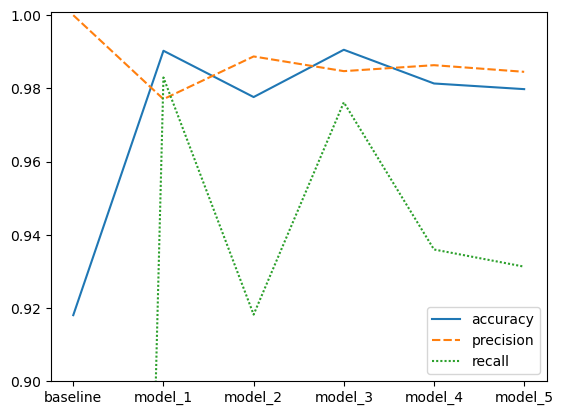

In [417]:
sb.lineplot(metrics_df[['accuracy', 'precision', 'recall']])
plt.ylim(0.9, 1.001)